In [1]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

In [2]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])



In [3]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [125]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.3 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    if conf==True:
        conf_mult= 1
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

## 1. (a) Experiments with no covariates in the DGP (do not control any covariates)

$y_i = \tau*T_i+e_i$
 

In [68]:
tau = 2 # treatment effect
corr = .3 # corr between covariates
conf=False # confounder
p =10 # number of covariates generated
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 495/495 [00:01<00:00, 280.08it/s]


In [69]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:14<00:00, 136.07it/s]


In [70]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    

N=100: bias=-0.004756327866832036, RMSE=0.19584042722347184, size=0.0525
N=1000: bias=-0.0007629977761247004, RMSE=0.0620269524783794, size=0.051


## 1.(b) Experiments with covariates in the DGP

$y_i = \tau*T_i+\beta'*x_i+e_i$

In [71]:
tau = 2
corr = .3
conf=False
p = 10
p0 = 3 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 1
(nvalues1,tauhats1,sehats1,lb1,ub1) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)


100%|████████████████████████████████████████| 450/450 [00:01<00:00, 250.76it/s]


In [72]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,10,3,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:15<00:00, 126.17it/s]


In [10]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    

N=100: bias=0.004316997640906438, RMSE=0.1436391319150795, size=0.0555
N=1000: bias=0.00011584689422283634, RMSE=0.04452920913747773, size=0.05


### Compare the results we get from a to b, we can see that when we control for covariates, the bias is getting smaller, RMSE goes down showing that we are getting better at estimating the treatment effect. The size of treatment effect is exactly at 5% when we test with 1000 sample size in (b), which is more precise than the size in (a). Since we test at 5%, the size of treatment effect is expected to be at 5%. 

## DAG Example

In this example, A directly affects dependent varibale E, at the same time, B, C and D are three other covariates that also influence the outcome of E.  

In [11]:
import graphviz as gr

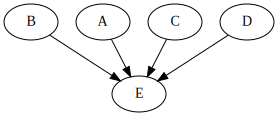

In [16]:
g = gr.Digraph()
g.edge("B", "E")
g.edge("A", "E")
g.edge("C", "E")
g.edge("D", "E")

g

## Real Life Example

### For example, we randomly assign a number of plants (plants have same characteristics) into two groups; in treated group, we increase the nutrients in soil, in control group, we maintain the level of nutrients unchanged, then we compare the results from two groups to see how nutrients in soil affects the outcome of how the plant performs. In this case, the outcome of how a plant perfoms mainly depends on the level of nutrients in soil, however, other varibales such as the amount of light the plants can receive, the temperature, and the level of moisture can also affect the result. 

## 2. (a) Experiments that when failing to control for the confounder

 $y_i = \tau*T_i+e_i$

In [146]:
tau = 2 # treatment effect
corr = 0.3 # corr between covariates
conf= False # confounder
p =10 # number of covariates generated
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 495/495 [00:01<00:00, 318.26it/s]


In [147]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:14<00:00, 135.79it/s]


In [148]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    

N=100: bias=-0.008512082082271815, RMSE=0.20050150852120743, size=0.048
N=1000: bias=0.0007853713722454434, RMSE=0.06350013909504715, size=0.053


## 2. (b) Experiments that when controlling for the confounder

$y_i = \tau*T_i+\beta'*x_i+confmult*0.6*C+e_i$


In [149]:
tau = 2
corr = .3
conf=True
p = 10
p0 = 1 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 1
(nvalues_2,tauhats_2,sehats_2,lb_2,ub_2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 450/450 [00:01<00:00, 260.73it/s]


In [150]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)): 
        Yexp,T,X = fn_generate_data(tau,N,10,1,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:15<00:00, 129.17it/s]


In [151]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.001961635568096632, RMSE=0.16042633542175405, size=0.0585
N=1000: bias=0.00015584692015435864, RMSE=0.05196055200915378, size=0.0515


### Compare the results we get from a to b, we can see that when we control for the confounder, the bias is getting smaller, showing that we reduce chances of overestimating or underestimating the result, and RMSE goes down showing that we are getting better at estimating the treatment effect. The size of treatment effect is getting closer to 5% for size=1000.

## DAG Example

In this example, independent varibale A directly affects dependent varibale C, at the same time, B is a confounding variable that affect independent variable A as well as the outcome of C. 

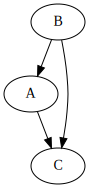

In [152]:
g = gr.Digraph()
g.edge("A", "C")
g.edge("B", "A")
g.edge("B", "C")


g


## Real Life Example

### For example, we observe that increased smoking leads to more disease; however, other variables such as  emotional stress could also cause smoking as well as disease. In this case, emotional stress is the confounder that both affect independent varible and dependent varible. 

## 3. (a) Experiments that when controlling for the variable in between the path from cause to effect

$y_i = \tau*T_i+\beta'*x_i+confmult*0.6*C+e_i$

In [155]:
tau = 2
corr = .3
conf=True
p = 10
p0 = 3 # add two other variables that in between the path
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 1
(nvalues3,tauhats3,sehats3,lb3,ub3) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|████████████████████████████████████████| 450/450 [00:01<00:00, 249.06it/s]


In [157]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)): 
        Yexp,T,X = fn_generate_data(tau,N,10,3,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:19<00:00, 104.19it/s]


In [158]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0015467282599026242, RMSE=0.1635148765307156, size=0.058
N=1000: bias=0.0013377122643154443, RMSE=0.050963541713635846, size=0.049


## 3. (b) Experiments that when not controlling for the variable in between the path from cause to effect

$y_i = \tau*T_i+\beta'*x_i+confmult*0.6*C+e_i$

In [163]:
tau = 2
corr = .3
conf=True
p = 10
p0 = 1 # do not add varibales that in between the path
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 1
(nvalues_3,tauhats_3,sehats_3,lb_3,ub_3) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|████████████████████████████████████████| 450/450 [00:03<00:00, 134.04it/s]


In [164]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)): 
        Yexp,T,X = fn_generate_data(tau,N,10,1,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 71.81it/s]


In [165]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0033521459411679833, RMSE=0.16404534519603345, size=0.055
N=1000: bias=0.0002488916964088329, RMSE=0.05229208640279333, size=0.0535


### Compare the results we get from a to b, we can see that when we not control for the variables in between the path from cause to effect, the bias is getting smaller, showing that we reduce chances of overestimating or underestimating the result; the RMSE and the size of treatment effect does not tell any significant difference. This indicates that we should not control for the variable in between the path, as those varibales are people select into.

## DAG Example

In this example, besides confonder varible B, there are two other varibles are in between the path from the cause A to effect C as well as from the cause B to effect C.  

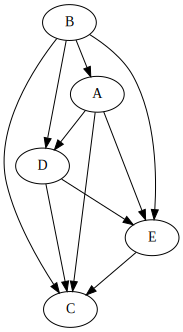

In [169]:
g = gr.Digraph()
g.edge("A", "C")
g.edge("B", "A")
g.edge("B", "C")
g.edge("A", "D")
g.edge("D", "C")
g.edge("B", "D")


g.edge("A", "E")
g.edge("E", "C")
g.edge("B", "E")
g.edge("D", "E")


g



## Real Life Example

### For example, we observe that advertisement leads to more sales of clothes, and Black Friday season is the confounding variable that can both leads to advertisement and sales of clothes; there could be two other variables that are in between the path from advertisement to sales of clothes as well as from Black Friday season to sales of clothes, such as "watch the advertisement" and then "trust the advertisement". These two varibles are in between the path from cause to effect that should not be controlled.